# <a id='toc1_'></a>[T23 State Space Control - Part 0](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [T23 State Space Control - Part 0](#toc1_)    
  - [State Space Control](#toc1_1_)    
  - [FSFB Place](#toc1_2_)    
    - [Compute the Bessel Pole Locations](#toc1_2_1_)    
    - [Example using Bessel Pole Locations](#toc1_2_2_)    
    - [ITAE Optimize](#toc1_2_3_)    
    - [ITAE step response](#toc1_2_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [36]:
import requests as req, os

URL = "https://raw.githubusercontent.com/mit-acl/16_06_Class/main/"
File = ["basic_material.py","control_materials.py"]

if not os.path.isfile(File[0]):
    print('Basic files not` found - downloading it')
    for dfile in File:
        if not os.path.isfile(dfile):
            print(dfile)
            res = req.get(URL+dfile)
            file = open(dfile, 'w')
            file.write(res.text)
            file.close()
else:
    print('Basic file found')
from basic_material import *

j = complex(0,1)

from scipy.optimize import minimize
from scipy.signal import butter,bessel
from control.matlab import tf, ss, tf2ss, step, place
from control_materials import *

Basic file found


## <a id='toc1_1_'></a>[State Space Control](#toc0_)

Nbar =-15.00


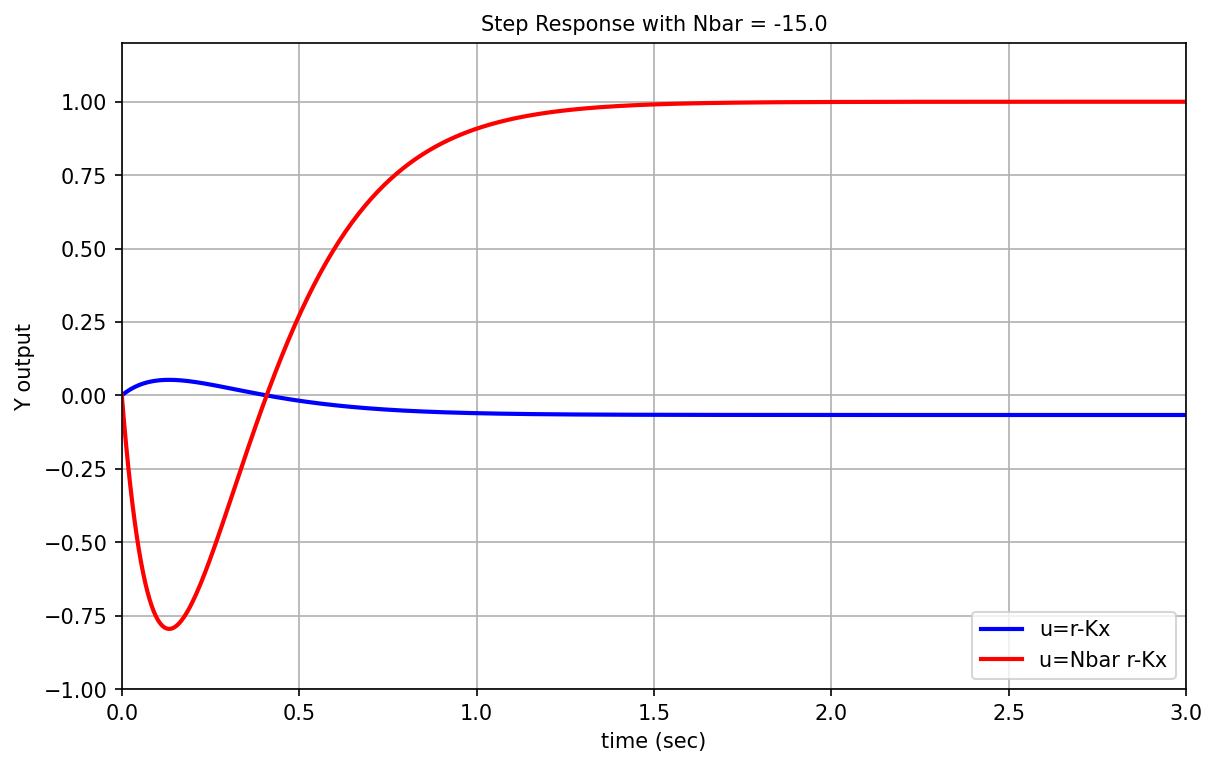

In [37]:
# full state feedback for topic 23
# reference input issues
#
a = np.array([[1, 1],[1, 2]])
nx = np.shape(a)[0]
b = np.array([1, 0]).reshape(nx,1)
c = np.array([1, 0])
d = 0

p = np.array([-5, -6])
# gains assumed found
k = place(a, b, p)

Nbar = 1/(-c@np.linalg.inv(a-b*k)@b).item()
print(f"{Nbar =: 4.2f}")
sys1 = ss(a-b*k,b,c,d)
sys2 = ss(a-b*k,b*Nbar,c,d)

t = np.linspace(0,3,500)
y,t = step(sys1,t)
y2,t2 = step(sys2,t)

fig, ax = plt.subplots(1,figsize=(8, 5),dpi=150,constrained_layout = True)
plt.plot(t,y,'b-',label='u=r-Kx')
plt.plot(t2,y2,'r-',lw=2,label='u=Nbar r-Kx')
plt.axis([0, max(t), -1, 1.2])
plt.legend(loc=4)
plt.xlabel('time (sec)')
plt.ylabel('Y output')
plt.title('Step Response with'+f" {Nbar = : 3.1f}")
savefig("figs/Nbar.pdf", dpi=600)
plt.show()

## <a id='toc1_2_'></a>[FSFB Place](#toc0_)

In [38]:
def compute_Nbar(G,k0):
    Nbar0 = 1.0/np.dot(-G.C,np.dot(np.linalg.inv(G.A-np.dot(G.B,k0)),G.B)).item()
    return Nbar0   

def FSFB_place(G,pr,file_name='temp',w=np.logspace(-1,2,400),Tmax=1):
    #
    k0 = place(G.A,G.B,pr)
    #
    # For state space for G_c(s)
    # find the feedforward gains
    Nbar0 = compute_Nbar(G,k0)

    sys0 = ss(G.A-G.B*k0,G.B,G.C,G.D);
    sys1 = ss(G.A-G.B*k0,G.B*Nbar0,G.C,G.D);

    Gf = G(w*j)
    sys0f = sys0(j*w)
    sys1f = sys1(j*w)
    ymax = max(np.max(np.abs(Gf)),np.max(np.abs(sys0f)),np.max(np.abs(sys1f)))
    ymax = 10**np.ceil(np.log10(1.5*ymax))

    t = np.arange(0,Tmax,.01)    
    y0,t0 = step(sys0,T=t)
    y1,t1 = step(sys1,T=t)

    fig, ax = plt.subplots(1,figsize=(8, 5),dpi=150,constrained_layout = True)
    ax.plot(t0,y0,'g-',label=r'$u=r-Kx$')
    ax.plot(t1,y1,'r-',label=r'$u=Nr-Kx$')
    plt.legend()
    plt.text(max(t0)/2,.8,f"{Nbar =:3.1f}", fontsize=16)
    plt.ylabel("Response")
    plt.xlabel("Time")
    savefig("figs/FSFB_pl"+file_name+"_0.pdf", dpi=600)
    plt.show()

    fig, ax = plt.subplots(2,1,figsize=(8, 5),dpi=150,constrained_layout = True)
    ax[0].loglog(w,np.abs(Gf),'b',label=r'G')
    ax[1].semilogx(w,np.unwrap(np.angle(Gf))*r2d,'b',label=r'G')
    ax[0].loglog(w,np.abs(sys0f),'g',label=r'$u=r-Kx$')
    ax[1].semilogx(w,np.unwrap(np.angle(sys0f))*r2d,'g',label=r'$u=r-Kx$')
    ax[0].loglog(w,np.abs(sys1f),'r',label=r'$u=Nr-Kx$')
    ax[1].semilogx(w,np.unwrap(np.angle(sys1f))*r2d,'r',label=r'$u=Nr-Kx$')

    ax[1].set_xlabel('Freq [r/s]')
    ax[0].set_ylabel('Mag')
    ax[1].set_ylabel('Phase (degs)')
    ax[0].grid(True, which="both", ls="-",color='0.65')
    ax[1].grid(True, which="both", ls="-",color='0.65')
    ax[0].axhline(y=1,c='k',ls='--')
    ax[1].axhline(y=-180,c='k',ls='--')
    ax[0].legend()
    ax[0].set_ylim(1e-3,ymax)
    savefig("figs/FSFB_pl"+file_name+"_1.pdf", dpi=600)
    plt.show()

    return k0

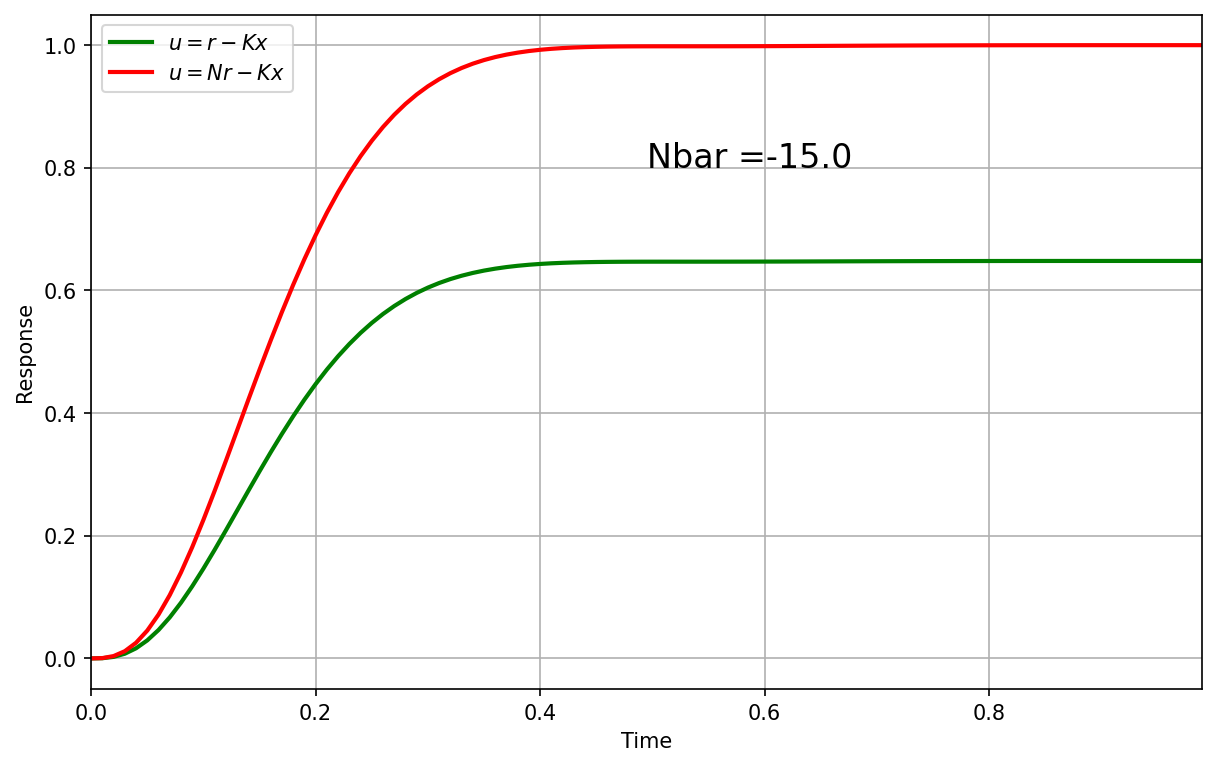

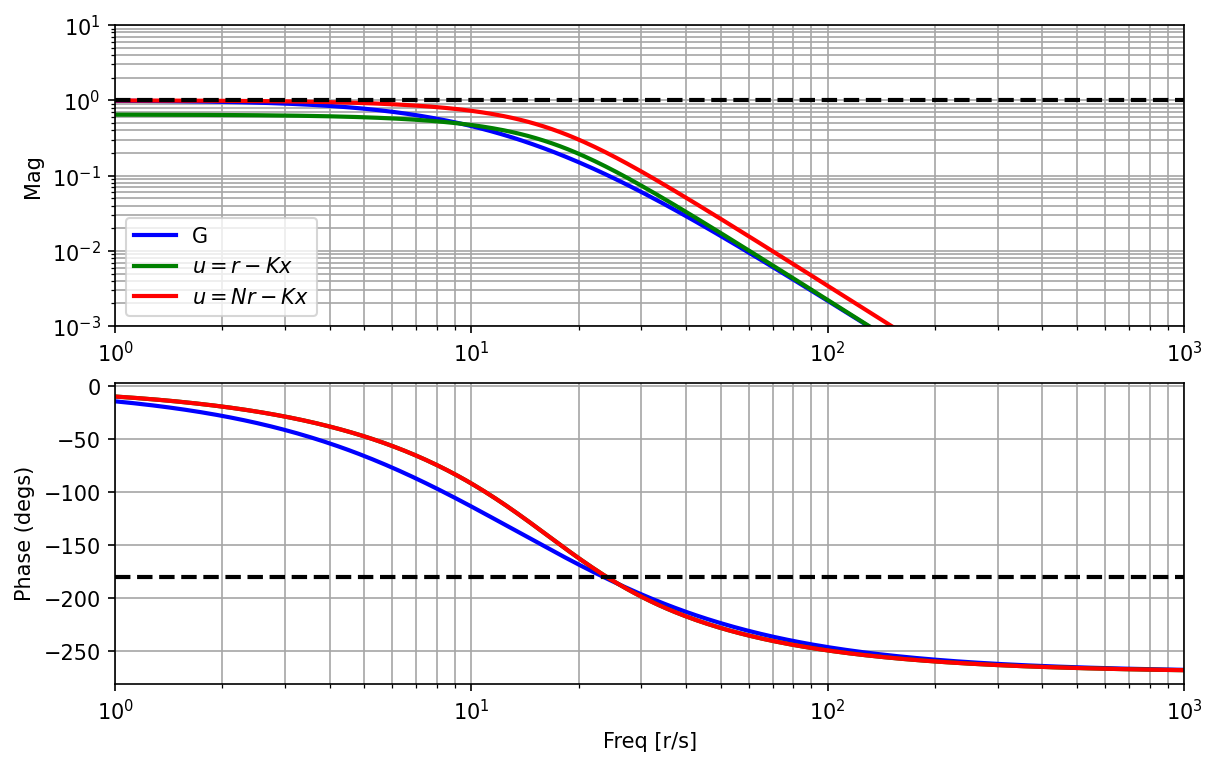

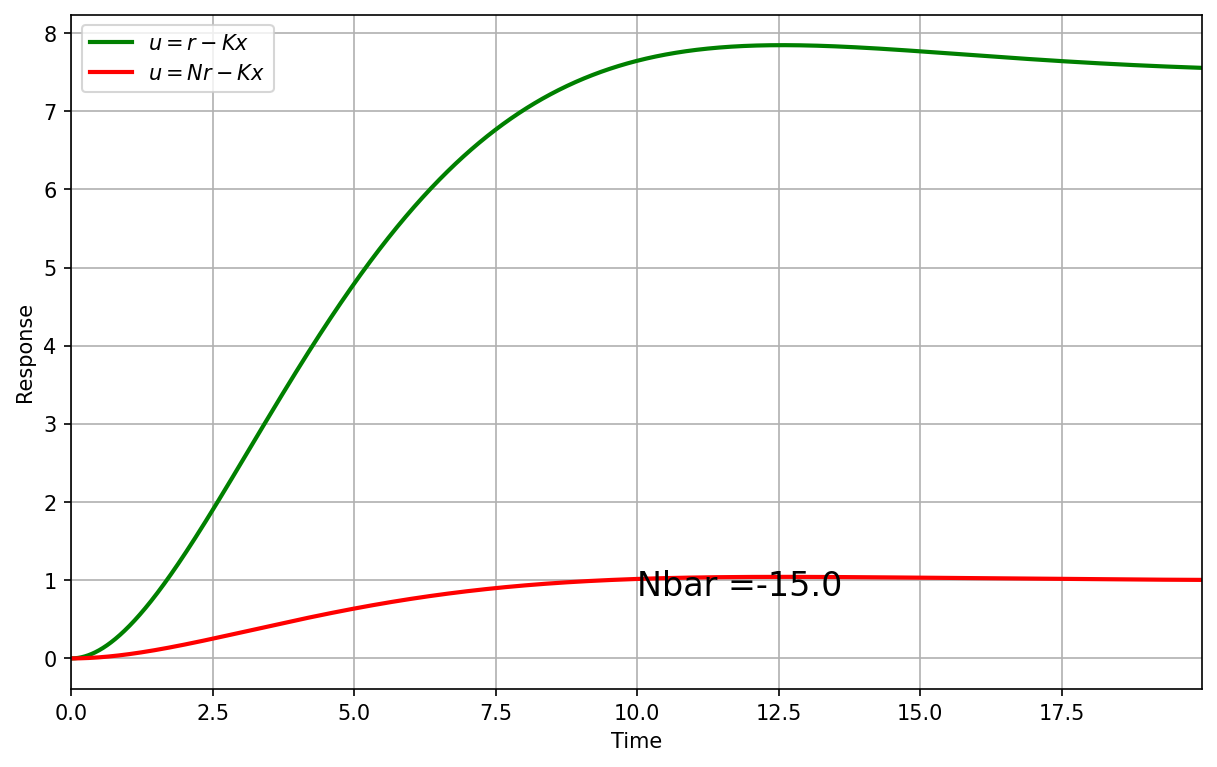

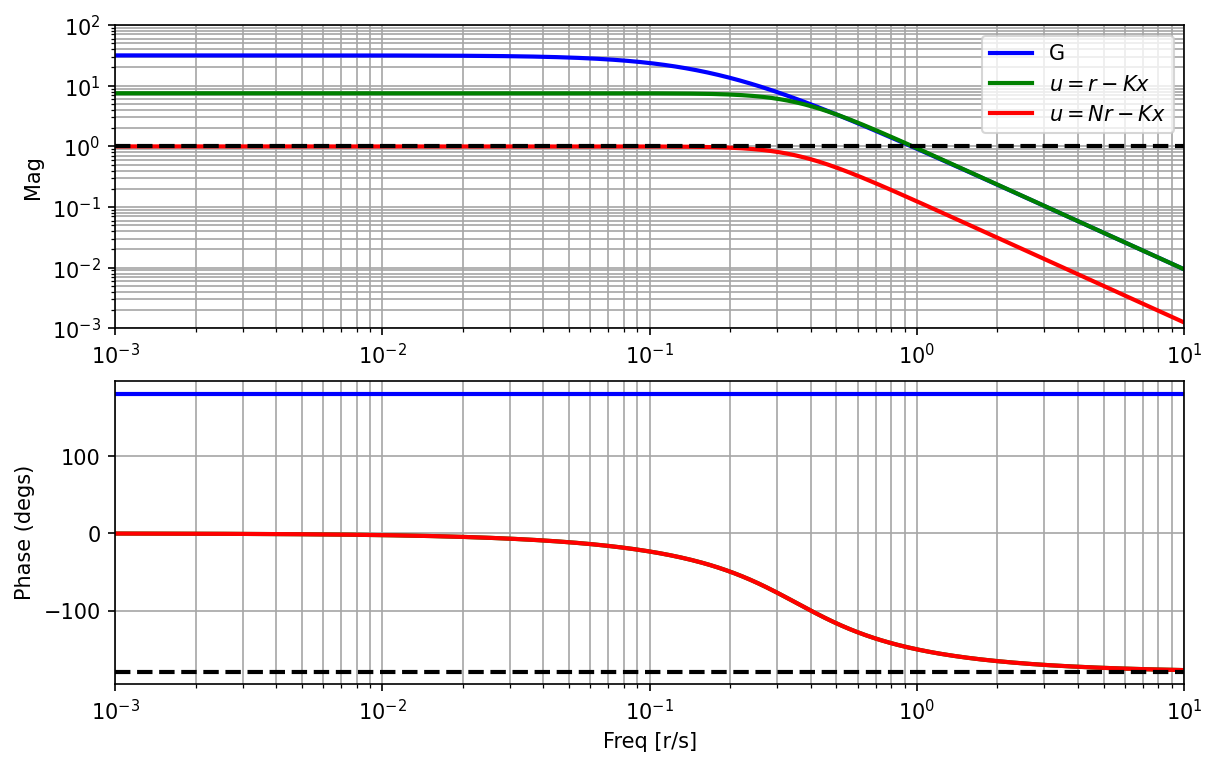

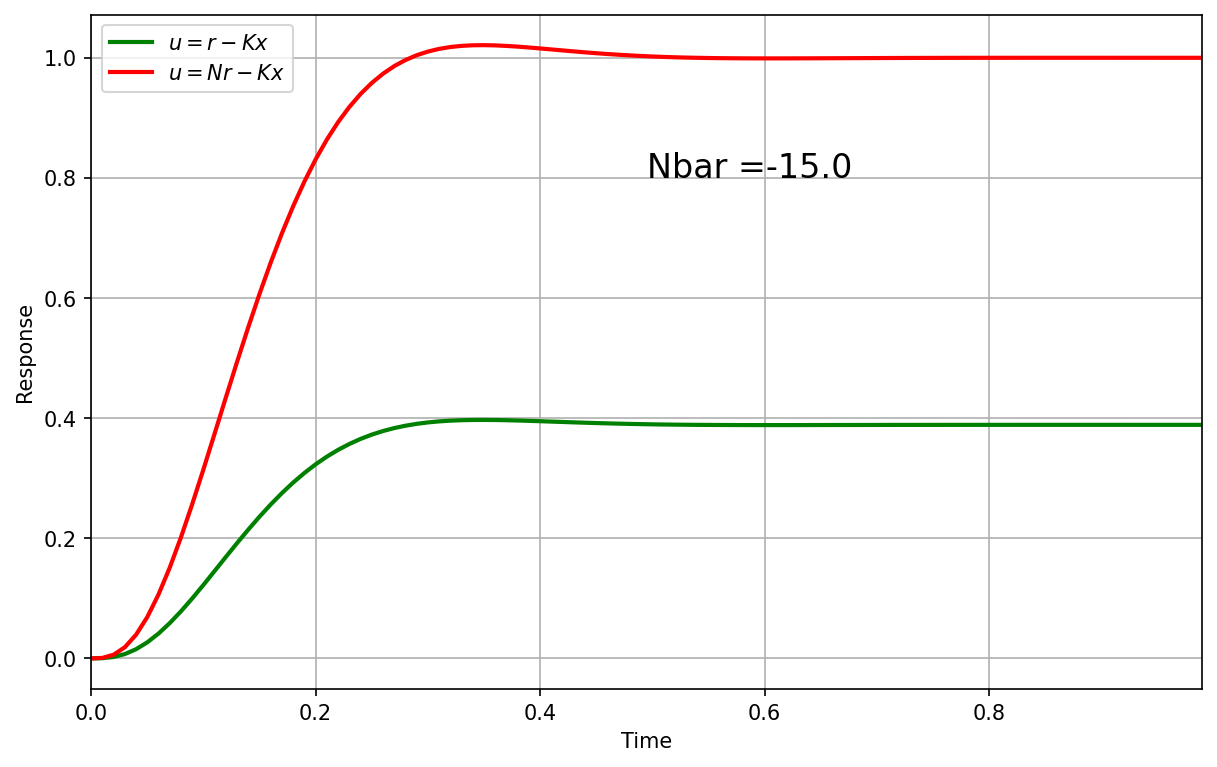

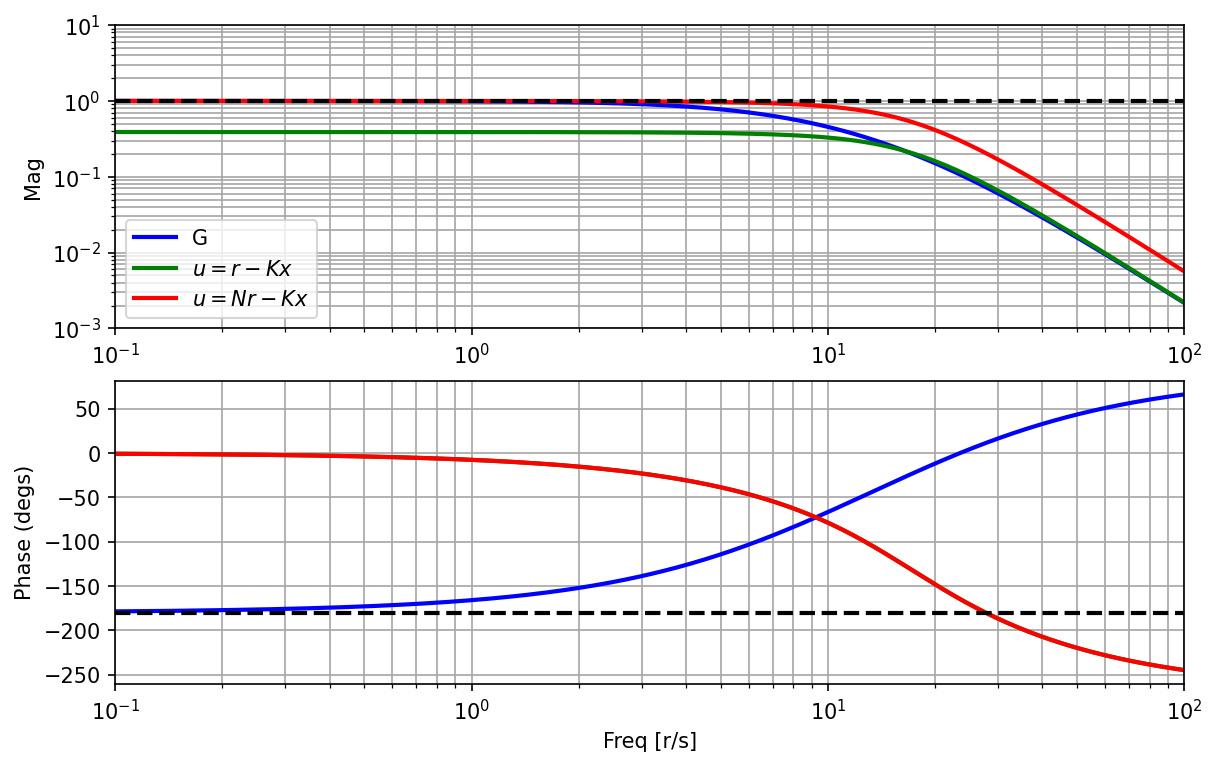

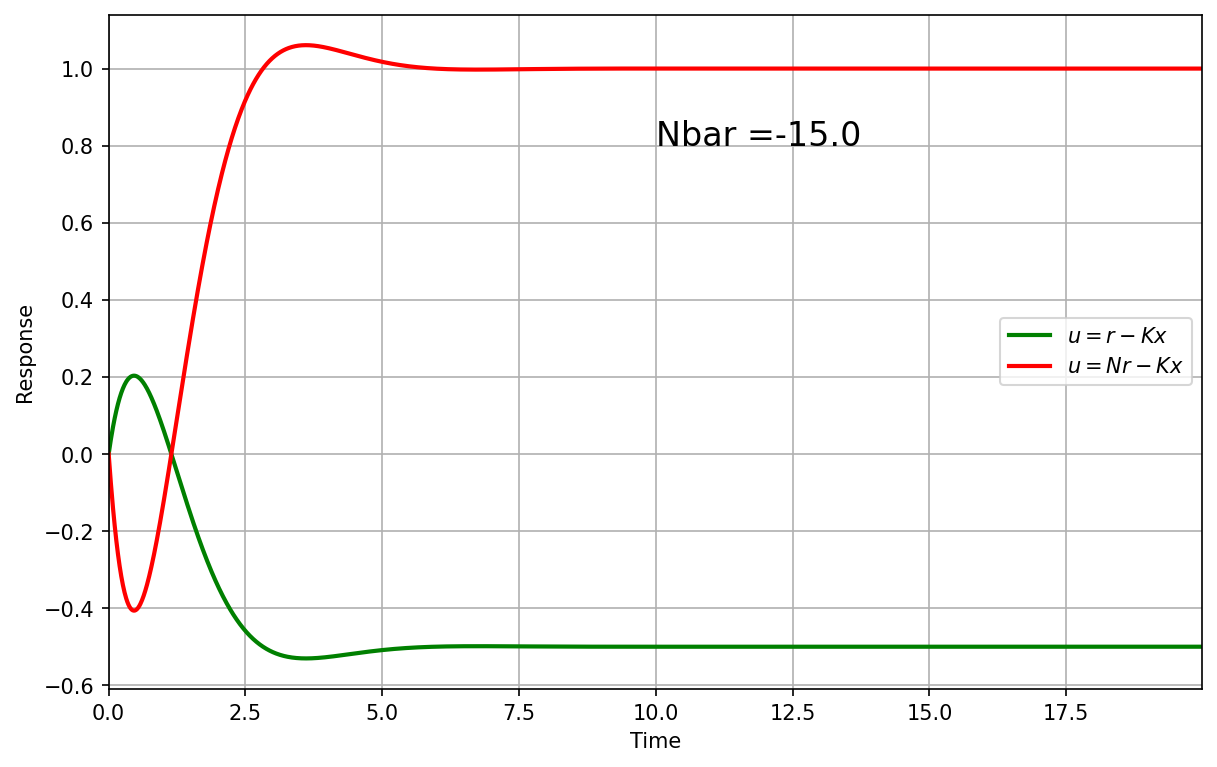

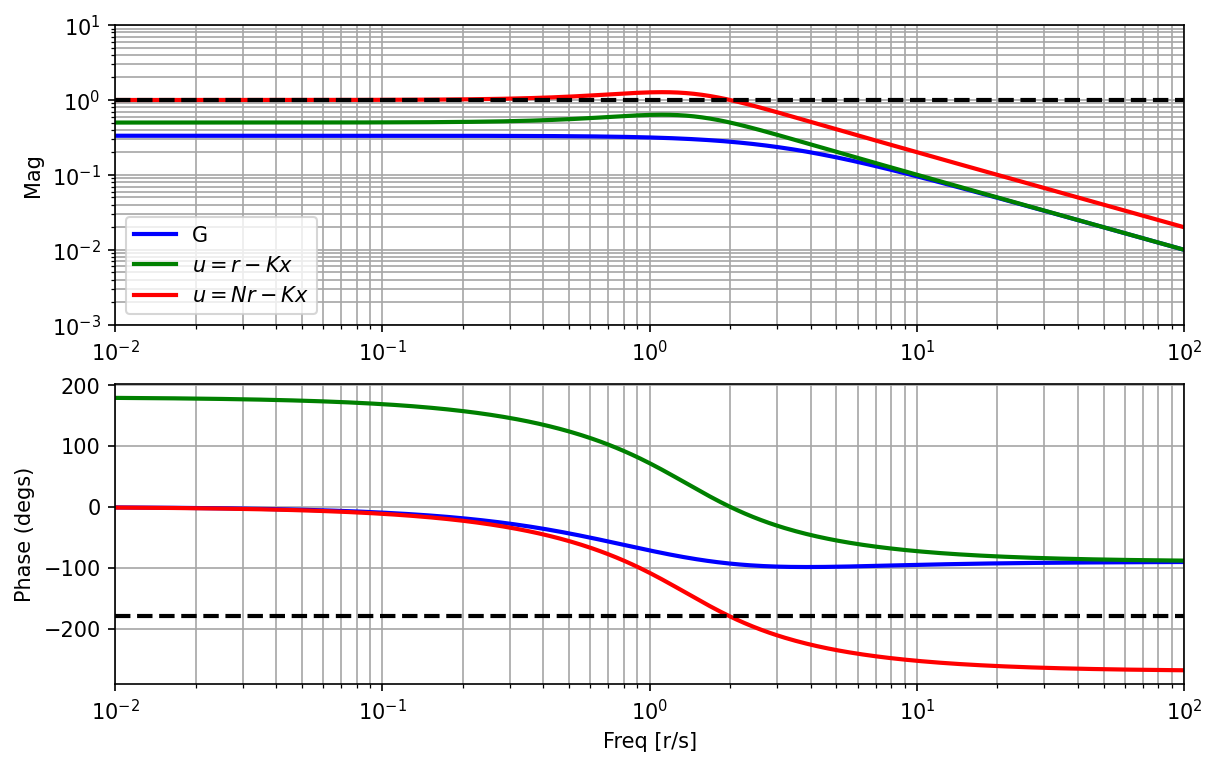

In [39]:
G1 = ss(tf(8*14*20,np.convolve([1, 8],np.convolve([1, 14],[1, 20]))))
pr = np.array([-12,-12+12*j,-12-12*j])
K1 = FSFB_place(G1,pr,file_name='examp1',w = np.logspace(0,3,400))

G2 = ss(tf(0.94,(1,0,-0.0297)))
pr = np.array([-0.25+0.25*j,-0.25-0.25*j])
K2 = FSFB_place(G2,pr,file_name='examp2',Tmax=20,w = np.logspace(-3,1,400))

G3 = ss(tf(8*14*20,np.convolve([1, -8],np.convolve([1, -14],[1, -20]))))
pr = np.array([-20,-12+12*j,-12-12*j])
K3 = FSFB_place(G3,pr,file_name='examp3', w = np.logspace(-1,2,400))

G4 = ss(tf((1,-1),(1,-2,-3)))
pr = np.array([-1+j,-1-j])
K4 = FSFB_place(G4,pr,file_name='examp4',Tmax=20,w = np.logspace(-2,2,400))


### <a id='toc1_2_1_'></a>[Compute the Bessel Pole Locations](#toc0_)

n = 1: -4.600
n = 2: (-4.03 + 2.33i), (-4.03 + -2.33i)
n = 3: (-3.95 + 3.77i), (-3.95 + -3.77i), -4.990
n = 4: (-3.99 + 5.04i), (-3.99 + -5.04i), (-5.50 + 1.65i), (-5.50 + -1.65i)
n = 5: (-4.09 + 6.28i), (-4.09 + -6.28i), -6.416, (-5.90 + 3.07i), (-5.90 + -3.07i)
n = 6: (-4.20 + 7.50i), (-4.20 + -7.50i), (-6.24 + 4.38i), (-6.24 + -4.38i), (-7.09 + 1.45i), (-7.09 + -1.45i)


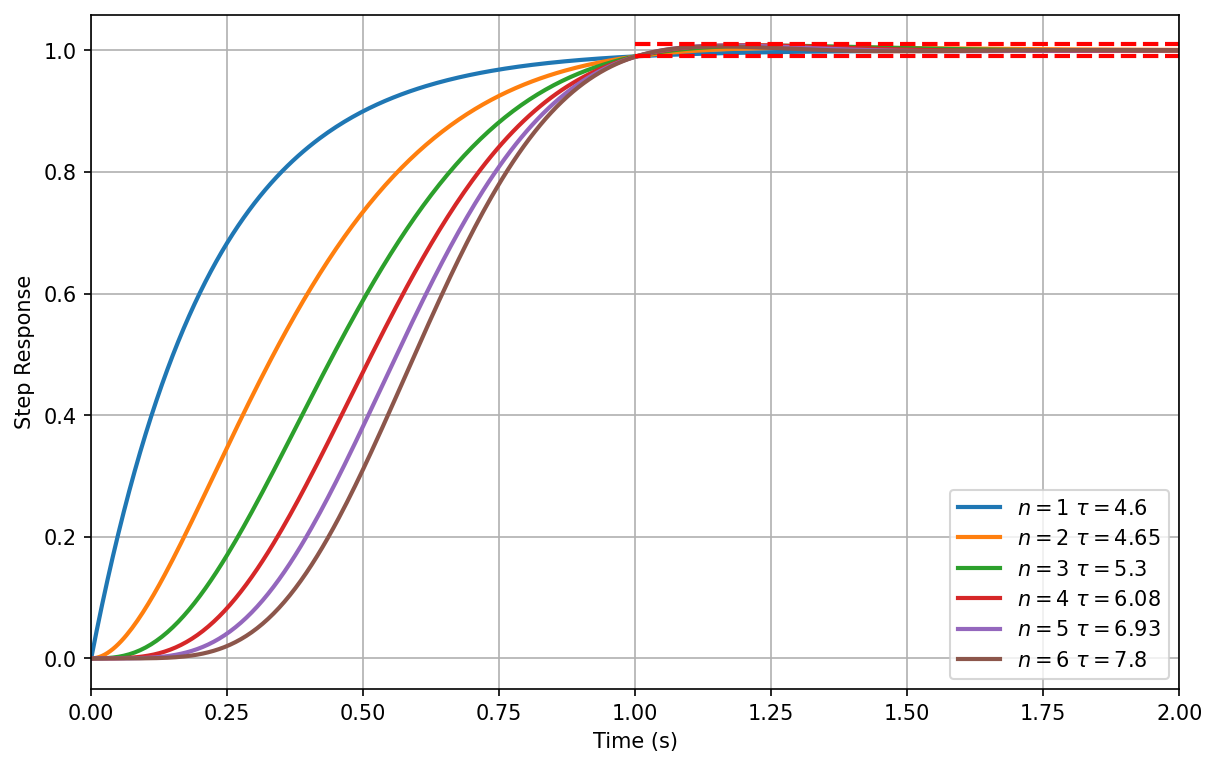

In [40]:
Bessel_poles={}

Npts = 2000
t_Bessel = np.linspace(0, 10, Npts)
ts_targ = 1
Tol = 0.01

def func(tau,t,a,b,Tol=0.01):
    n = len(a) - 1
    AA = [float(xx/tau**(n - kk)) for kk, xx in enumerate(a)]
    y,_ = step(control.matlab.tf(b,AA),T=t)
    # Find the index where y is within 2% of the final value
    index = np.where(np.abs(y - 1) >= Tol)[0][-1]
    return (1.0 - t[index])**2

fig, ax = plt.subplots(1,figsize=(8, 5),dpi=150,constrained_layout = True)
for n in range(1,7):
    b, a = bessel(n, 1, analog=True)
    sol = minimize(func, x0 = 1,method='Nelder-Mead',args=(t_Bessel,a,b),tol=1e-4)
    tau = sol.x[0]  # Extract the scalar value from the array
    A = [float(xx / tau**(n - kk)) for kk, xx in enumerate(a)]
    y_Bessel,_ = step(tf(b, A), T=t_Bessel)
    plt.plot(t_Bessel, y_Bessel,label=r'$n = $'+str(n)+r' $\tau=$'+str(np.round(tau,2)))
    Bessel_poles[n] = np.roots(A)
    pretty_row_print(np.roots(A),"n = "+str(n)+": ")

plt.legend()
plt.axhline(y=(1+Tol),ls='--',xmin=1/2,c='r')
plt.axhline(y=(1-Tol),ls='--',xmin=1/2,c='r')
plt.xlim(0,2)
plt.ylabel('Step Response')
plt.xlabel('Time (s)')
savefig("figs/Bessel_step_response.pdf", dpi=600)
plt.show()

### <a id='toc1_2_2_'></a>[Example using Bessel Pole Locations](#toc0_)

n = 3
(-3.95 + 3.77i), (-3.95 + -3.77i), -4.990
(-1.98 + 1.89i), (-1.98 + -1.89i), -2.495
[-1.97594702+1.88512156j -1.97594702-1.88512156j -2.49524007+0.j        ]


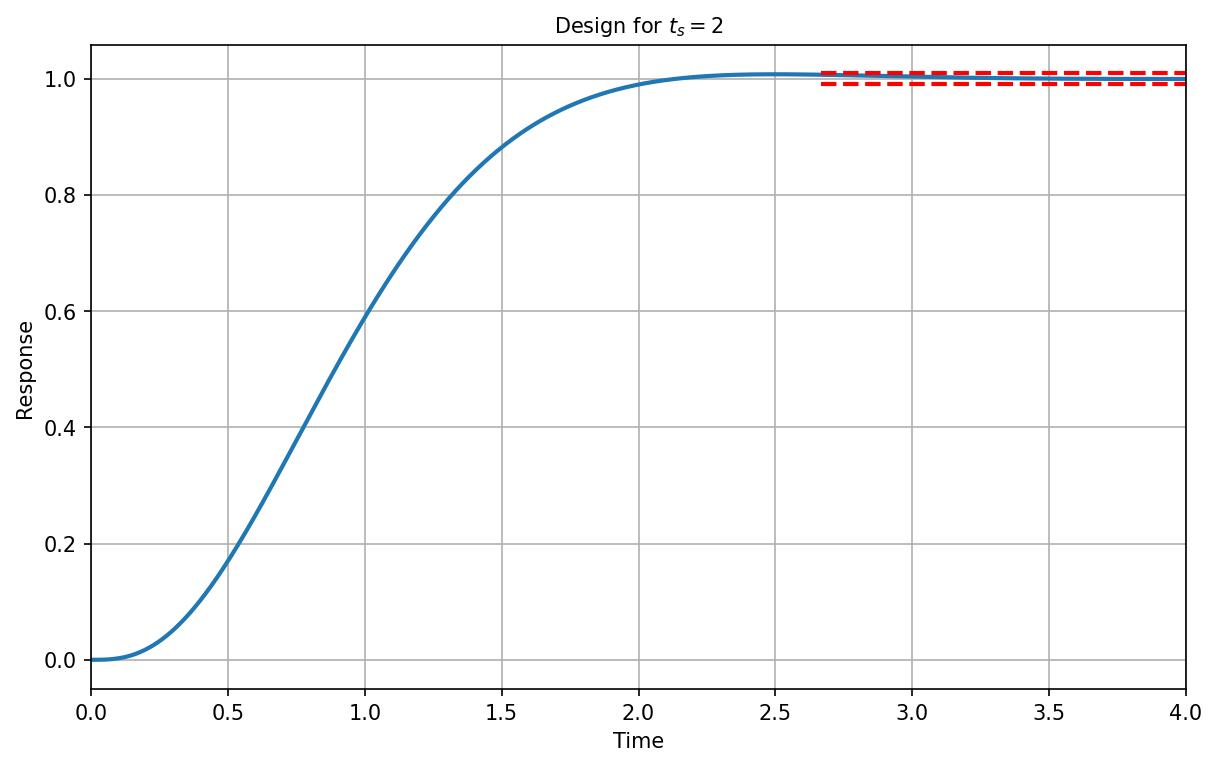

In [41]:
# system
G = tf(1,[1 ,0]) * tf(1,[1 ,4]) * tf(1,[1 ,1])
n = len(G.den[0][0]) - 1
print(f"{n =: 2d}")
Gss = tf2ss(G)
tau = 2 # scaling factor on time constant
#get p from above cell
if 0:
    p = (complex(-3.95,3.77), complex(-3.95, -3.77), complex(-4.99 , 0.00))
else:
    p = Bessel_poles[n]
pretty_row_print(p)
p_scaled = [pp/tau for pp in p]
pretty_row_print(p_scaled)

K = place(Gss.A,Gss.B,p_scaled)
Acl = Gss.A-Gss.B @ K
print(np.linalg.eig(Acl)[0])
Nbar = compute_Nbar(Gss,K)
Gcl = Nbar*ss(Acl,Gss.B,Gss.C,Gss.D)

t_Bessel = np.linspace(0,2*tau,Npts)
y_Bessel,t_Bessel = step(Gcl,T=t_Bessel)

fig, ax = plt.subplots(1,figsize=(8, 5),dpi=150,constrained_layout = True)
plt.plot(t_Bessel,y_Bessel)
plt.axhline(y=(1+Tol),ls='--',xmin=tau/max(t),c='r')
plt.axhline(y=(1-Tol),ls='--',xmin=tau/max(t),c='r')
plt.ylabel("Response")
plt.xlabel("Time")
plt.title('Design for $t_s=$'+str(tau))
savefig("figs/Bessel_1.pdf", dpi=600)
plt.show()

### <a id='toc1_2_3_'></a>[ITAE Optimize](#toc0_)


n = 2
Coeffs: 1.000, 1.506, 1.000
ITAE_mine = 1.952
Poles: (-0.75 + 0.66i), (-0.75 + -0.66i)
Scaled Poles: (-4.96 + 4.33i), (-4.96 + -4.33i)

n = 3
Coeffs: 1.000, 1.781, 2.171, 1.000
ITAE_mine = 3.138
Poles: (-0.54 + 1.06i), (-0.54 + -1.06i), -0.709
Scaled Poles: (-4.46 + 8.82i), (-4.46 + -8.82i), -5.901

n = 4
Coeffs: 1.000, 1.941, 3.339, 2.642, 1.000
ITAE_mine = 4.586
Poles: (-0.39 + 1.33i), (-0.39 + -1.33i), (-0.58 + 0.42i), (-0.58 + -0.42i)
Scaled Poles: (-3.88 + 13.35i), (-3.88 + -13.35i), (-5.87 + 4.27i), (-5.87 + -4.27i)

n = 5
Coeffs: 1.000, 2.038, 4.470, 4.637, 3.247, 1.000
ITAE_mine = 6.296
Poles: (-0.28 + 1.51i), (-0.28 + -1.51i), (-0.46 + 0.74i), (-0.46 + -0.74i), -0.557
Scaled Poles: (-3.31 + 17.83i), (-3.31 + -17.83i), (-5.41 + 8.70i), (-5.41 + -8.70i), -6.562

n = 6
Coeffs: 1.000, 2.045, 5.529, 6.720, 6.695, 3.701, 1.000
ITAE_mine = 8.237
Poles: (-0.19 + 1.66i), (-0.19 + -1.66i), (-0.35 + 0.98i), (-0.35 + -0.98i), (-0.48 + 0.31i), (-0.48 + -0.31i)
Scaled Poles: (-2.62 +

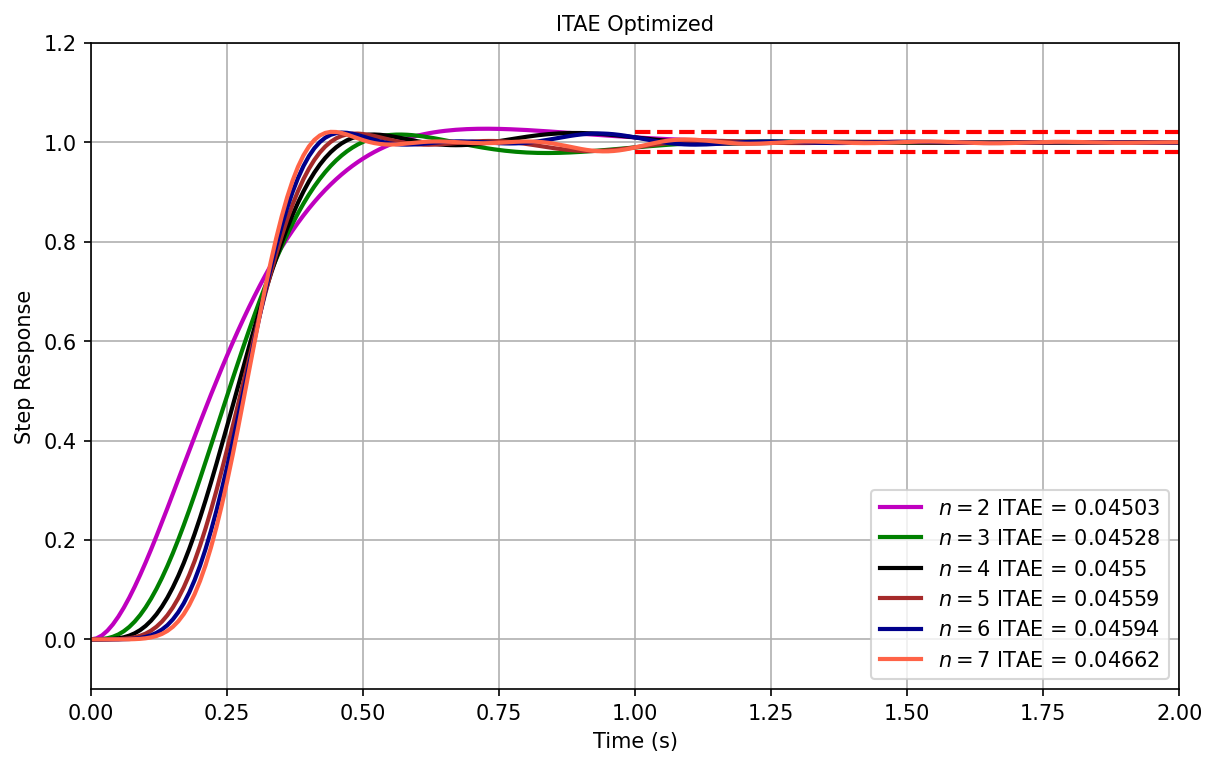

In [42]:
Npts = 2000
Tf = 20
t_ITAE = np.linspace(0, Tf, Npts)
ts_targ = 1.0

def func(a,t):
    A = [1] + list(np.flip(a)) + [1]
    y,_ = step(tf(1, A), T = t)
    abs_error = np.abs(1 - y)
    ITAE = np.trapezoid(t * abs_error,t)
    return ITAE

itaeOrg = {
    2: [1.505],
    3: [1.783, 2.172],
    4: [1.953,    3.347,    2.648],
    5: [2.068,    4.499,    4.675,    3.257],
    6: [3.25, 6.60, 8.60, 7.45, 3.95],
    7: [4.475, 10.42, 15.08, 15.54, 10.64, 4.58],
    8: [5.2, 12.8, 21.6, 25.75, 22.2, 13.3, 5.15]
}
X =[]
global X
def itaecost(p,t_ITAE):
    global X
    nn = len(p)
    dt = t_ITAE[1] - t_ITAE[0]
    A = np.zeros((nn + 1, nn + 1))
    A[:-1,1:] = np.eye(nn)
    A[-1, :] = -np.array([1] + list(p))   
    pp = [1]+list(np.flip(p))+[1]
    #print(pp)
    #pretty_row_print(np.roots(pp),"Poles: ")
    #pretty_row_print(np.linalg.eig(A)[0],"Eigenvalues: ")
    B = np.zeros((nn + 1, 1))
    B[-1] = 1
    AB = np.block([[A, B], [np.zeros((1, nn + 2))]])
    exp_AB = expm(AB * dt)
    x = np.zeros((nn + 2, 1))
    x[-1] = 1
    E = 0
    e_old = 0
    for tt in t_ITAE:
        X = np.append(X,x[0,0])
        x = exp_AB @ x.reshape(nn+2, 1)
        e = 1 - x[0,0]
        E += (abs(e_old) * (tt) + abs(e) * (tt+dt))/2.0 * dt
        e_old = e 
    return E

def my_pfe(A,t) :
    from scipy.signal import residue
    A = np.convolve(A, [1, 0])  # Multiply by s to get the correct order
    rr, pp, kk = residue([1], A)
    # Compute the time response of each term
    time_responses = []
    for residue, pole in zip(rr, pp):
        response = residue * np.exp(pole * t)
        time_responses.append(response)

    # Combine the responses to get the total response
    total_response = np.sum(time_responses, axis=0)
    return total_response

fig, ax = plt.subplots(1,figsize=(8, 5),dpi=150,constrained_layout = True)
ITAE_poles = {}
ITAE_scaled_poles = {}
check_old = False
plot_scaled = True

for n in range(2,8):
    print(f"\n{n =: 2d}")
    if check_old:
        sol = minimize(itaecost, x0=itaeOrg[n], args=(t_ITAE), method='Nelder-Mead', tol=1e-9)
    else:
        sol = minimize(func, x0=itaeOrg[n], args=(t_ITAE), method='Nelder-Mead', tol=1e-9)

    A = [1]+list(np.flip(sol.x))+[1]
    ITAE_poles[n] = np.roots(A)
    pretty_row_print(A,"Coeffs: ")

    y_ITAE,_ = step(tf(1, A), T=t_ITAE)
    abs_error = np.abs(1.0 - y_ITAE)
    ITAE_mine = np.trapezoid(t_ITAE * abs_error,t_ITAE)
    print(f"{ITAE_mine = :.3f}")

    if check_old:
        X =[]
        ITAE = itaecost(sol.x,t_ITAE)
        print(f"Old {ITAE = :.3f}")

    try:
        index = np.where(np.abs(y_ITAE - 1) >= 0.01)[0][-1]
        tau = t_ITAE[index]
    except:
        tau = 1
    # time scaling
    AA = [float(xx / tau**(n - kk)) for kk, xx in enumerate(A)]
    ITAE_scaled_poles[n] = np.roots(AA)

    y_scaled_ITAE,_ = step(tf(1, AA), T=t_ITAE)
    abs_scaled_error = np.abs(1.0 -y_scaled_ITAE)
    ITAE_scaled_mine = np.trapezoid(t_ITAE * abs_scaled_error,t_ITAE)

    pretty_row_print(ITAE_poles[n],"Poles: ")
    pretty_row_print(ITAE_scaled_poles[n],"Scaled Poles: ")

    if plot_scaled:
        plt.plot(t_ITAE,y_scaled_ITAE,label=r'$n = $'+str(n)+r' ITAE = '+str(np.round(ITAE_scaled_mine,5)),c=colors[n],lw=2)
    else:
        plt.plot(t_ITAE, y_ITAE,label=r'$n = $'+str(n),c=colors[n],lw=2)

if check_old:
    plt.plot(t_ITAE,X,'k--',label='Old ITAE = '+str(np.round(ITAE,5)),lw=2)
    plt.plot(t_ITAE, 1e12*(X - y_ITAE),label='1e12 Old Error')

if plot_scaled:
    Pred_resp = my_pfe(AA,t_ITAE)
    Err2 = np.abs(Pred_resp - y_scaled_ITAE)
else:
    Pred_resp = my_pfe(A,t_ITAE)
    Err2 = np.abs(Pred_resp - y_ITAE)

if 0:
    plt.plot(t_ITAE,Pred_resp,'c--',label='Analytic ITAE',lw=3)
    plt.plot(t_ITAE, 1e12*Err2,label='1e12 Error2')

plt.axhline(y=1.02,ls='--',xmin=1/2,c='r')
plt.axhline(y=1/1.02,ls='--',xmin=1/2,c='r')
if plot_scaled:
    plt.xlim(0,2)
else:
    plt.xlim(0,Tf)

plt.ylim(-0.1,1.2)
plt.ylabel('Step Response')
plt.xlabel('Time (s)')
plt.title("ITAE Optimized")
plt.legend()
plt.savefig("figs/ITAE_step_response.pdf", dpi=600)
plt.show()

### <a id='toc1_2_4_'></a>[ITAE step response](#toc0_)

ITAE poles(-4.46 + 8.82i), (-4.46 + -8.82i), -5.901
Scaled poles(-2.23 + 4.41i), (-2.23 + -4.41i), -2.950
Eigenvalues (-2.23 + 4.41i), (-2.23 + -4.41i), -2.950


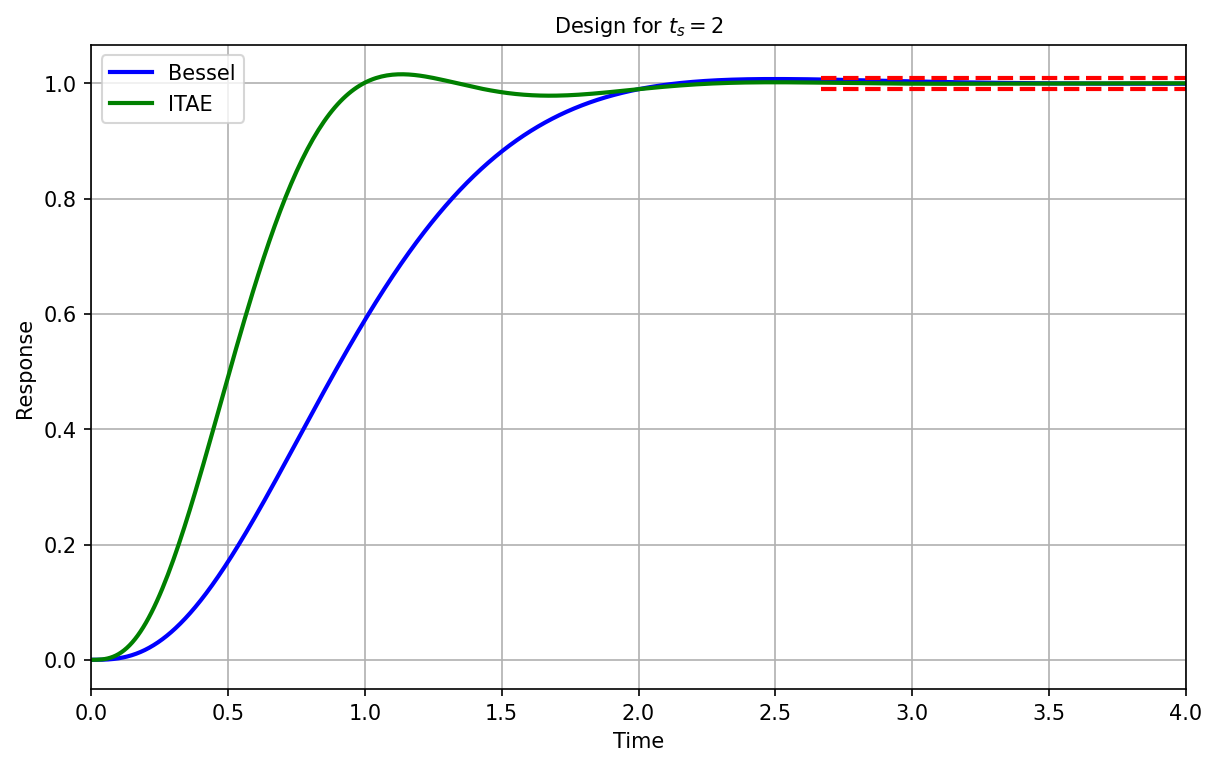

In [43]:
Tol = 0.01
tau = 2
n = 3
if 0:
    p = (complex(-4.350,8.918),complex(-4.350,-8.918),complex(-5.913))
else:
    p = ITAE_scaled_poles[n]
pretty_row_print(p, "ITAE poles")
p_scaled = [pp/tau for pp in p]
pretty_row_print(p_scaled, "Scaled poles")

K = place(Gss.A,Gss.B,p_scaled)
Acl = Gss.A-Gss.B @ K
pretty_row_print(np.linalg.eig(Acl)[0],"Eigenvalues ")
Nbar = compute_Nbar(Gss,K)
Gcl = Nbar*ss(Acl,Gss.B,Gss.C,Gss.D)

y_ITAE,_ = step(Gcl,T=t_ITAE)

fig, ax = plt.subplots(1,figsize=(8, 5),dpi=150,constrained_layout = True)
plt.plot(t_Bessel,y_Bessel,'b',label='Bessel')
plt.plot(t_ITAE,y_ITAE,'g',label='ITAE')
plt.axhline(y=y_ITAE[-1]*(1+Tol),ls='--',xmin=tau/max(t),c='r')
plt.axhline(y=y_ITAE[-1]*(1-Tol),ls='--',xmin=tau/max(t),c='r')
plt.ylabel("Response")
plt.xlabel("Time")
plt.xlim(0,2*tau)
plt.legend()
plt.title('Design for $t_s=$'+str(tau))
savefig("figs/Bessel_2.pdf", dpi=600)
plt.show()


In [49]:
# Save Bessel_poles and ITAE_scaled_poles to pole_locations.py
with open("pole_locations.py", "w") as f:
    f.write("# This file contains pole location data\n\n")
    f.write("import numpy as np\n\n")
    f.write("from control_materials import *\n\n")

    f.write("Bessel_poles = {\n")
    for key, value in Bessel_poles.items():
        f.write(f"    {key}: {list(value)},\n")
    f.write("}\n\n")
    
    f.write("ITAE_scaled_poles = {\n")
    for key, value in ITAE_scaled_poles.items():
        f.write(f"    {key}: {list(value)},\n")
    f.write("}\n")

    f.write("if __name__ == '__main__':\n")
    f.write("    print('Bessel_poles:', Bessel_poles)\n")
    f.write("    print('ITAE_scaled_poles:', ITAE_scaled_poles)\n")
    

In [50]:
from pole_locations import *
print("\nBessel poles")

for key, value in Bessel_poles.items():
    pretty_row_print(value,str(key)+": ")

print("\nITAE poles")
    
for key, value in ITAE_scaled_poles.items():
    pretty_row_print(value,str(key)+": ")


Bessel poles
1: -4.600
2: (-4.03 + 2.33i), (-4.03 + -2.33i)
3: (-3.95 + 3.77i), (-3.95 + -3.77i), -4.990
4: (-3.99 + 5.04i), (-3.99 + -5.04i), (-5.50 + 1.65i), (-5.50 + -1.65i)
5: (-4.09 + 6.28i), (-4.09 + -6.28i), -6.416, (-5.90 + 3.07i), (-5.90 + -3.07i)
6: (-4.20 + 7.50i), (-4.20 + -7.50i), (-6.24 + 4.38i), (-6.24 + -4.38i), (-7.09 + 1.45i), (-7.09 + -1.45i)

ITAE poles
2: (-4.96 + 4.33i), (-4.96 + -4.33i)
3: (-4.46 + 8.82i), (-4.46 + -8.82i), -5.901
4: (-3.88 + 13.35i), (-3.88 + -13.35i), (-5.87 + 4.27i), (-5.87 + -4.27i)
5: (-3.31 + 17.83i), (-3.31 + -17.83i), (-5.41 + 8.70i), (-5.41 + -8.70i), -6.562
6: (-2.62 + 22.42i), (-2.62 + -22.42i), (-4.73 + 13.28i), (-4.73 + -13.28i), (-6.46 + 4.24i), (-6.46 + -4.24i)
7: (-1.93 + 26.92i), (-1.93 + -26.92i), (-4.10 + 17.86i), (-4.10 + -17.86i), (-5.99 + 8.67i), (-5.99 + -8.67i), -6.991
